# <center> Evaluate Learned primal dual </center>

In [1]:
import adler
adler.util.gpu.setup_one_gpu(1)


from adler.odl.phantom import random_phantom as random_phantom_jonas
from adler.tensorflow import prelu, cosine_decay

import tensorflow as tf

import numpy as np
import odl
import odl.contrib.tensorflow
import warnings
warnings.filterwarnings('ignore')
import math
import os

Picking GPU 1


In [2]:
np.random.seed(0)
#name = os.path.splitext(os.path.basename(__file__))[0]
name = os.path.splitext(os.getcwd())[0]+'/checkpoints'

In [3]:
sess = tf.InteractiveSession()

**Define space and operator**

In [4]:
# Create ODL data structures
size = 128
space_image = odl.uniform_discr([-64, -64], [64, 64], [size, size],
                          dtype='float32')

In [5]:
import odl.trafos.wavelet as wavelet

In [6]:
# Wavelet analysis operator
wavean= wavelet.WaveletTransform(domain = space_image,wavelet = 'db2', nlevels = 4)

In [7]:
# Wavelet synthesis operator
wavesyn = wavean.inverse


In [8]:
# Wavelet coefficietns space
space = wavesyn.domain

In [9]:
# Using as backend scikit-image
geometry = odl.tomo.parallel_beam_geometry(wavesyn.range, num_angles=30)
ray_operator= odl.tomo.RayTransform(wavesyn.range, geometry)

In [10]:
operator = odl.operator.operator.OperatorComp(ray_operator,wavesyn)

In [11]:
# Ensure operator has fixed operator norm for scale invariance
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [12]:
# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator,
                                                          'RayWaveTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint,
                                                                  'RayWaveTransformAdjoint')

In [13]:
# User selected paramters
n_data = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [14]:
def generate_data(validation=False):
    """Generate a set of random data."""
    n_generate = 1 if validation else n_data

    y_arr = np.empty((n_generate, operator.range.shape[0], operator.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate,space.shape[0],1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = wavean(odl.phantom.shepp_logan(space_image, True))
        else:
            phantom = wavean(random_phantom(space_image))

        data = operator(phantom)
        noisy_data = data + odl.phantom.white_noise(operator.range) * np.mean(np.abs(data)) * 0.05
        
        x_true_arr[i,...,0] = phantom
        y_arr[i, ..., 0] = noisy_data
        
    return y_arr, x_true_arr

In [15]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, wavean.range.shape[0],1], name="x_true")
    y_rt = tf.placeholder(tf.float32, shape=[None, operator.range.shape[0], operator.range.shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

In [16]:
def apply_conv_primal(x, filters=32):
    return tf.layers.conv1d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

In [17]:
def apply_conv_dual(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

In [18]:
primal_values = []
dual_values = []

In [19]:
with tf.name_scope('tomography'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            update = prelu(apply_conv_dual(update), name='prelu_1')
            update = prelu(apply_conv_dual(update), name='prelu_2')
            update = apply_conv_dual(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            update = prelu(apply_conv_primal(update), name='prelu_1')
            update = prelu(apply_conv_primal(update), name='prelu_2')
            update = apply_conv_primal(update, filters=n_primal)
            primal = primal + update
        
        primal_values.append(primal)
        dual_values.append(dual)

    x_result = primal[..., 0:1]

In [20]:
# Initialize all TF var\iables
sess.run(tf.global_variables_initializer())

In [21]:
ckp_name = name+'_lpd_wavelets/checkpoints'

In [22]:
# Add op to save and restore
saver = tf.train.Saver()

if 1:
    saver.restore(sess,adler.tensorflow.util.default_checkpoint_path(ckp_name))

INFO:tensorflow:Restoring parameters from /store/kepler/datastore/andrade/GitHub_repos/tfshearlab/Paper_experiments/Python/checkpoints_lpd_wavelets/checkpoints.ckpt


In [23]:
# Generate validation data
y_arr_validate, x_true_arr_validate = generate_data(validation=True)

In [24]:
primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                      feed_dict={x_true: x_true_arr_validate,
                                 y_rt: y_arr_validate,
                                 is_training: False})

In [64]:
result_primal = np.array(wavean.inverse(space.element(primal_values_result[-1][0, ..., 0])))
true_primal = np.array(wavean.inverse(space.element(x_true_arr_validate[0,:,0])))

In [65]:
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

In [66]:
print(ssim(result_primal, true_primal))

0.8557642341


In [69]:
print(psnr(result_primal, true_primal, data_range=1))

24.4360423099


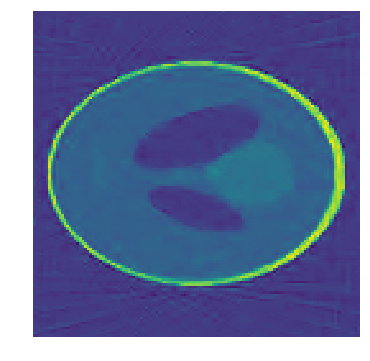

In [72]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(result_primal)
plt.savefig('../results/LPD/lpd_results_wavelets.png')